In [1]:
import custom_system_properties as csp

In [2]:
import matplotlib.pyplot as plt

In [3]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [4]:
import oommfc as oc

## Main parameters

In [5]:
system = mm.System(name='breaking2022macedo')

system_prop = csp.SystemProperties(lx=102, ly=1, lz=1)
system_prop.cell = (10e-9, 4e-9, 4e-9)
system_prop.units = ('m', 'm', 'm')
system_prop.update_lengths()
system_prop.update_numcells()

In [6]:
# Saturisation magnetisation
Ms = 800e3  # kA/m

# exchange stiffness
A = (43.5 * Ms * system_prop.cell[0])/2

# External static Zeeman field strength
H0 = tuple(x/mm.consts.mu0 for x in [0, 0, 0.1])  # A/m

# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [3e-3, 0, 0])  # A/m

# Driving frequency
f = 42.5e9  # Hz

# Stepsize at which equations are evaluated
h = 1e-15  # s

## Regions

In [7]:
%%capture
system_region = csp.MyRegions(system.name + "_regions")

system_region.main(p1=system_prop.p1, p2=system_prop.p2, 
                   dims=('x', 'y', 'z'), units=system_prop.units)

In [8]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.p1, 
                           p2=system_prop.cell, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.fixedLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.p2, system_prop.cell, 
                                       mult=5, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)
system_subregions.free(p1=csp.add_tuples(system_subregions.driven.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.p2, system_prop.cell, mult=95, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)
system_subregions.fixedRhs(p1=csp.add_tuples(system_region.main.p2, system_prop.cell, 
                                         mult=-1, dims='x', base=system_prop.p1),
                           p2=system_region.main.p2, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

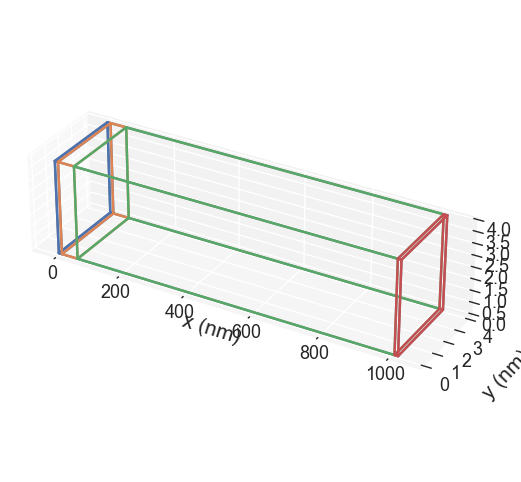

In [9]:
system_region._mesh = df.Mesh(region=system_region.main.region, 
                              cell=system_prop.cell,
                              subregions=system_subregions.regions)

system_region._mesh.mpl.subregions(multiplier=1e-9,box_aspect=(8, 2, 2), show_region=True)

### Energy equations

In [10]:
system_subregions.driven.region

Region(pmin=[1e-08, 0.0, 0.0], pmax=[6e-08, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm'])

In [11]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return h0
    else:
        return (0, 0, 0)
    #x, y, z = pos
    
    #if system_subregions.driven.p1[0] <= x < system_subregions.driven.p2[0]:
    #    return h0
    #else:
    #    return (0,0,0)

In [12]:
# system_subregions.driven.mesh = df.Mesh(region=system_region.main.region, cell=system_prop.cell)

In [13]:
h0_field = df.Field(mesh=system_region._mesh, nvdim=3, value=h0_func)
#region_values = {"region1": (1, 1, 1), "region2": (2, 2, 2)}
#h0_field.update_field_values(region_values)

In [14]:
system.energy = mm.Zeeman(H=H0, name='static') + mm.Exchange(A=A)

### dynamics

In [15]:
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=1e-4)

In [16]:
mag_vals = system_subregions.mag_vals
mag_vals['fixedLhs'] = (0, 0, 1)
mag_vals['fixedRhs'] = (0, 0, 1)
mag_vals

{'fixedLhs': (0, 0, 1),
 'driven': (0, 0, 1),
 'free': (0, 0, 1),
 'fixedRhs': (0, 0, 1)}

In [17]:
system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=mag_vals, norm=Ms)

### Relaxation

In [18]:
minD = oc.MinDriver()
minD.drive(system, fixed_subregions=['fixedLhs', 'fixedRhs'], verbose=2)

Running OOMMF (TclOOMMFRunner)[2024/05/27 15:58]... (1.0 s)


[None]

/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


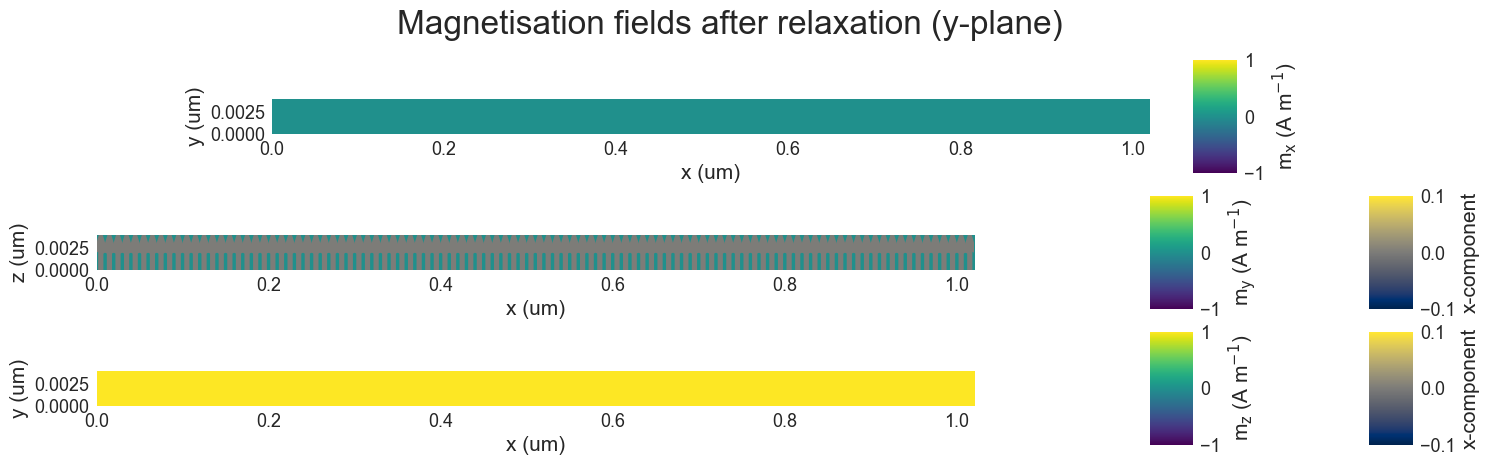

In [19]:
fig1, (fig1_ax1, fig1_ax2, fig1_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig1.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.orientation.x.sel('z').mpl(ax=fig1_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)",
                                                            'clim': (-1, 1)}, vector_kw={'vdims': ['x', 'y']})
fig1_ax1.set(aspect=10)

system.m.sel('y').mpl(ax=fig1_ax2, 
                                    scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)", 'clim': (-1, 1)},
                                    vector_kw={
                                    "cmap": "cividis",
                                    "use_color": True,
                                    "color_field": system.m.x.sel("z"),
                                    "colorbar": True,
                                    "colorbar_label": "x-component",
                                })
fig1_ax2.set(aspect=10)

system.m.sel('z').mpl(ax=fig1_ax3, 
                                    scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)",'clim': (-1, 1)},
                                    vector_kw={
                                    "cmap": "cividis",
                                    "use_color": True,
                                    "color_field": system.m.y.sel("z"),
                                    "colorbar": True,
                                    "colorbar_label": "x-component",
                                })
fig1_ax3.set(aspect=10)

/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


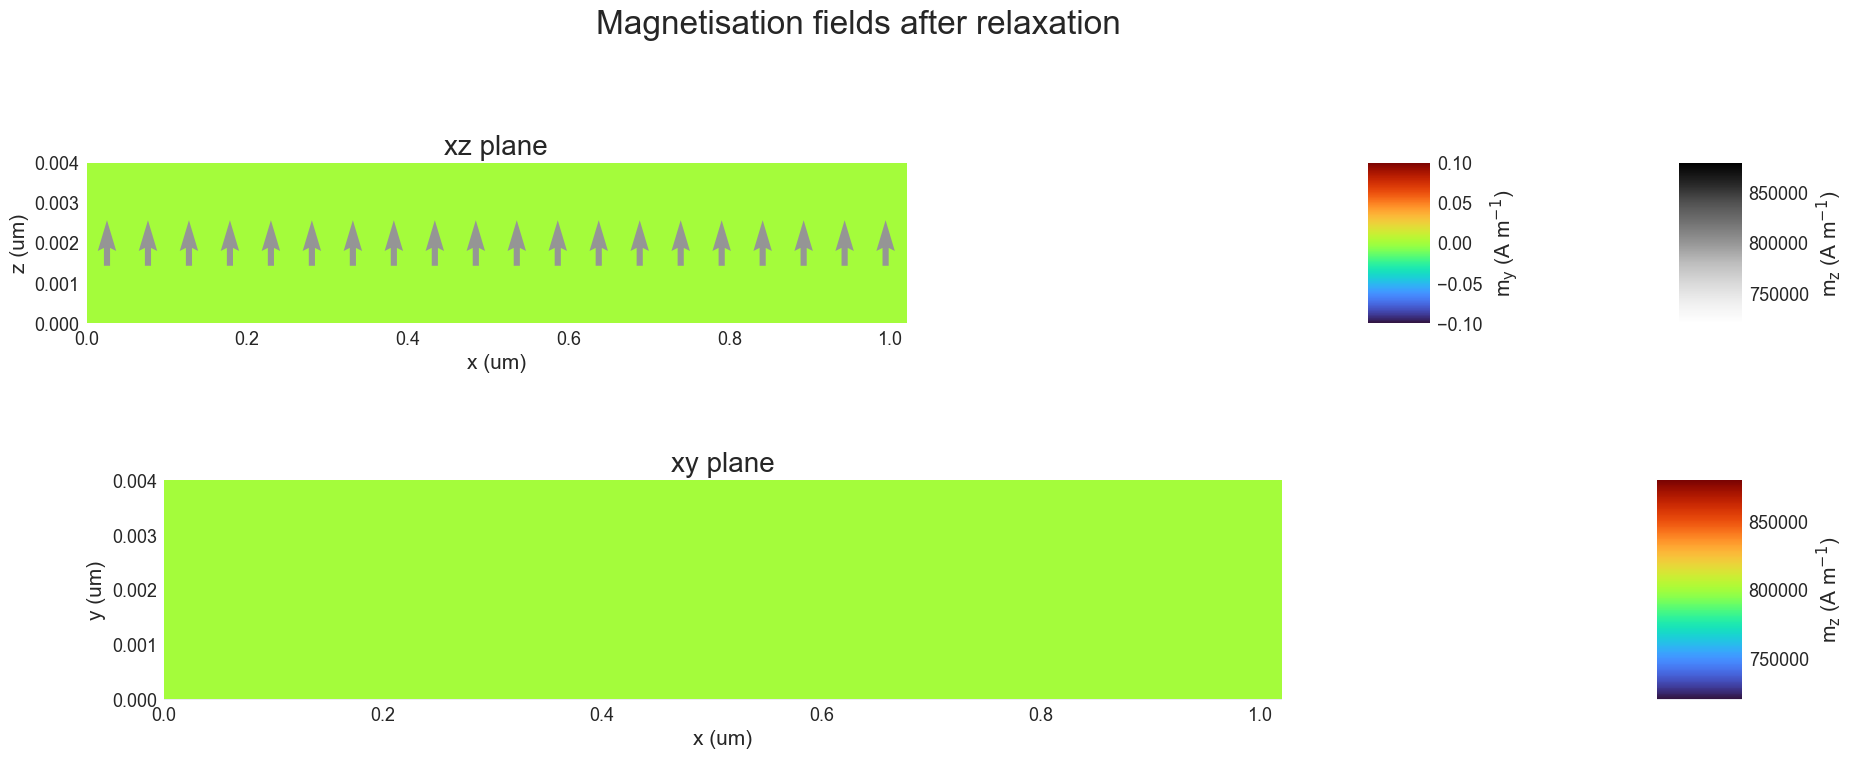

In [20]:
fig1, fig1_axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
fig1.suptitle('Magnetisation fields after relaxation', fontsize=24)


system.m.sel('y').y.mpl.scalar(ax=fig1_axs[0], cmap='turbo', colorbar_label='m$_\\text{y}$ (A m$^{-1}$)')
system.m.sel('y').resample((20, 1)).mpl.vector(ax=fig1_axs[0], 
                                               cmap='Greys',
                                               color_field = system.m.z.sel("y"),
                                               use_color=True,
                                               colorbar_label='m$_\\text{z}$ (A m$^{-1}$)')

fig1_axs[0].set(title='xz plane', aspect=50)

system.m.sel('z').mpl(fig1_axs[1],
                      scalar_kw={"colorbar_label": 'm$_\\text{z}$ (A m$^{-1}$)', "cmap": "turbo"}, 
                      vector_kw={"cmap": "turbo", "colorbar_label": 'm$_\\text{z}$ (A m$^{-1}$)', 
                                 'use_color': True, 'color_field': system.m.z.sel("z")})
fig1_axs[1].set(title='xy plane', aspect=50)

fig1.tight_layout()

In [21]:
#m = system.m.orientation

### Time-dependent field

In [22]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sin',f=f, t0=0,dt=h)

In [23]:
sim_evolver = oc.RungeKuttaEvolver(method='rk2',
                                          do_precess=1,
                                          allow_signed_gamma=0,
                                          max_timestep=h,
                                          )

td = oc.TimeDriver()#evolver=sim_evolver)

In [ ]:
td.drive(system, t=0.7e-9, n=100)

Running OOMMF (TclOOMMFRunner)[2024/05/27 15:58]... 

In [ ]:
fig2, (fig2_ax1, fig2_ax2, fig2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig2.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.x.sel("y").mpl(ax=fig2_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)"})
fig2_ax1.set(aspect=200)

system.m.y.sel('y').mpl(ax=fig2_ax2, scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)"})
fig2_ax2.set(aspect=200)

system.m.z.sel('y').mpl(ax=fig2_ax3, scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)"})
fig2_ax3.set(aspect=200)

In [ ]:
data = md.Data(system.name)
# Use only the last time drive
time_drive = data[-1]

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)